# Comparison between MADIREL internal dataset and NIST data


This notebook will perform the following:

- load both MADIREL and NIST datasets
- process common material-adsorbate pairs from both in a 10 degree temperature range.
- generate correlation graphs between the two KPI

Run this notebook with ``./notebooks`` as the root directory.

In [1]:
import json
import pathlib
import pickle
from collections import Counter

from tqdm import tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
import pandas as pd

import pygaps
plt.style.use('ggplot')

## Load the two datasets from database

In [2]:
# Database location
db_path = pathlib.Path.cwd().parent / "data" / "iso.db"

# Get all isotherms
isotherms = pygaps.db_get_isotherms(db_path, {})

print(f'Loaded {len(isotherms)} isotherms.')

Selected20913isotherms
Loaded 20913 isotherms.


In [3]:
# Database location
db_path_madirel = pathlib.Path.cwd() / "data" / "iso-madirel.db"

# Get all isotherms
iso_madirel = pygaps.db_get_isotherms(db_path_madirel, {})


rename = {'NaX' : 'Zeolite NaX', 'NaY' : 'Zeolite NaY'}

# Rename some materials
for iso in iso_madirel:
    if iso.material in rename:
        iso.material = rename[iso.material]

# Remove isotherms which are not recorded on as-synthesised material
iso_madirel = [iso for iso in iso_madirel if 'Pellets' not in iso.material_batch]

print(f'Final: {len(iso_madirel)} isotherms.')

Selected455isotherms
Final: 349 isotherms.


## Specify materials and probes

In [167]:
material_correspondence = {
    'HKUST-1(Cu)': 'CuBTC',                     
    'MIL-100(Al)': 'MIL-100(Al)',               
    'MIL-100(Cr)': 'MIL-100(Cr)',               
    'MIL-100(Fe)': 'MIL-100(Fe)',               
    'MIL-100(V)': 'MIL-100(V)',                 
    'MIL-101(Cr)': 'MIL-101(Cr)',               
    'MIL-125(Ti)': 'MIL-125(Ti)',               
    'MIL-125(Ti)-NH2': 'NH2-MIL-125',           
    'MIL-140A(Zr)': 'MIL-140A',                 
    'MIL-47(V)': 'MIL-47(V)',                   
    'MIL-53(Al)': 'MIL-53(Al)',                 
    'MIL-68(Al)': 'MIL-68(Al)',                 
    'Zeolite NaX': 'Zeolite NaX',               
    'Zeolite NaY': 'Zeolite NaY',               
    'UiO-66(Zr)': 'UiO-66',                      
    'UiO-66(Zr)-Br': 'UiO-66(Zr)-Br',           
    'UiO-66(Zr)-NH2': 'UiO-66(Zr)-NH2',         
}
probes = [
    'carbon monoxide',
    'carbon dioxide',
    'nitrogen',
    'methane',
    'ethane',
    'propane',
    'propene',
    'butane',
]

## Select common materials and adsorbates from the two datasets

In [108]:
sel_iso_madirel = [iso for iso in iso_madirel if
                iso.material in material_correspondence.keys() 
                and 293 < iso.temperature < 313 ]

madirel_dict = {}

for iso in tqdm(sel_iso_madirel):
    iso.henry_k = pygaps.initial_henry_slope(iso)

    try:
        iso.loading_p = iso.loading_at(0.5).item()
    except Exception:
        if 0.5 < min(iso.pressure(branch='ads')):
            iso.loading_p = iso.henry_k * 0.5
        else:
            iso.loading_p = np.nan

    madirel_dict[iso.iso_id] = {
        'mat' : iso.material,
        'ads' : str(iso.adsorbate),
        'kH' : iso.henry_k,
        'L' : iso.loading_p,
    }
madirel_pd = pd.DataFrame(madirel_dict).T

100%|██████████| 263/263 [00:26<00:00,  9.85it/s]


In [217]:
sel_iso_nist = [iso for iso in isotherms if 
                iso.material in material_correspondence.values() 
                and 293 < iso.temperature < 313 ]

nist_dict = {}

for iso in tqdm(sel_iso_nist):

    try:
        iso.loading_p = iso.loading_at(0.5).item()
    except Exception:
        if 0.5 < min(iso.pressure(branch='ads')):
            iso.loading_p = iso.henry_k * 0.5
        else:
            iso.loading_p = np.nan

    nist_dict[iso.filename] = {
        'mat' : list(material_correspondence.keys())[list(material_correspondence.values()).index(iso.material)],
        'ads' : str(iso.adsorbate),
        'kH' : iso.henry_k,
        'L' : iso.loading_p,
    }
nist_pd = pd.DataFrame(nist_dict).T

100%|██████████| 687/687 [00:00<00:00, 940.48it/s]


## Define statistical functions

In [7]:
from contextlib import contextmanager

@contextmanager
def _group_selection_context(groupby):
    """
    Set / reset the _group_selection_context.
    """
    groupby._set_group_selection()
    yield groupby
    groupby._reset_group_selection()

def stats(series):

    no_nan = series.dropna()
    size = len(no_nan)

    if size == 0:
        med, std = np.nan, 0
    elif size == 1:
        med, std = float(no_nan), 0
    elif 1 < size <= 4:
        med, std = np.median(no_nan), np.std(no_nan)
    elif 4 < size:
        # Computing IQR
        Q3, Q1 = np.nanpercentile(sorted(no_nan), [75, 25], interpolation='linear')
        IQR = Q3 - Q1
        o_rem = no_nan[(float(Q1 - 1.5 * IQR) < no_nan) | (no_nan > float(Q3 + 1.5 * IQR))]
        med, std = np.median(o_rem), np.std(o_rem)

    return pd.Series((size, med, std),
                     index=(["size", "med", "err"]),
                     name=series.name)

def calc_kpi(data):
    with _group_selection_context(data):
        return data.apply(
            lambda x: pd.concat(
                [stats(s) for _, s in x.items()],
                axis=1, sort=False)
        ).unstack()

## Plot correspondence graph

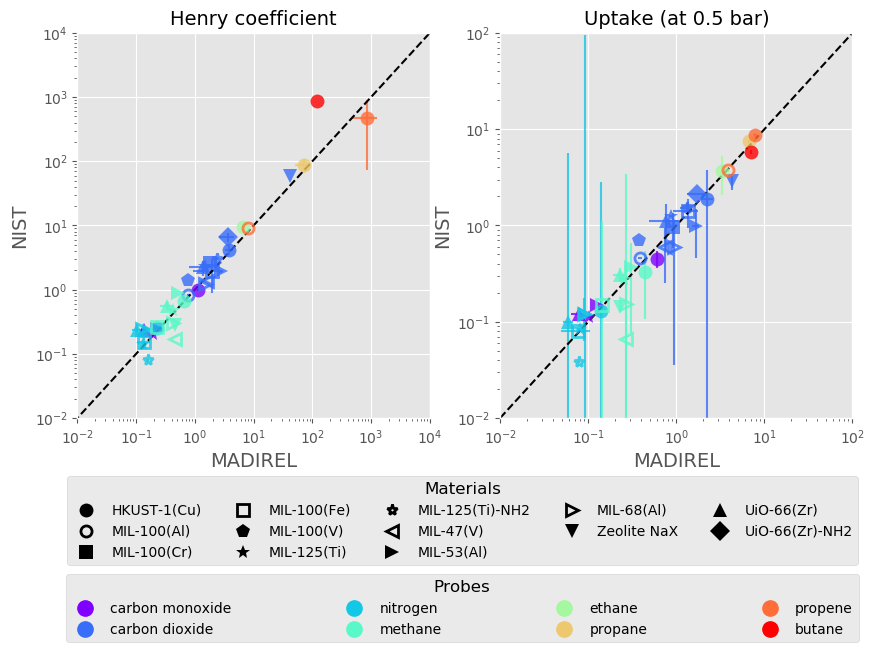

In [216]:
from matplotlib.lines import Line2D
mats = list(material_correspondence.keys())

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(probes)))
markers = list(cycler(marker=['o', 's', 'p', '*', '<', '>', 'v', '^', 'D', 'P']) *
               (cycler(mfc=[None, 'none']) + cycler(markeredgewidth=[0, 2]) + cycler(ms=[10, 8])))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

plotted = []
for ads in probes:
    kpi = pd.merge(
            calc_kpi(madirel_pd[madirel_pd['ads'] == ads].reset_index().drop(['ads', 'index'], axis=1).groupby('mat')),
            calc_kpi(nist_pd[nist_pd['ads'] == ads].reset_index().drop(['ads', 'index'], axis=1).groupby('mat')),
            on=('mat'), suffixes=('_x', '_y'))
    for mat in mats:
        if mat in kpi.index:
            plotted.append(mat)
            ax1.errorbar(
                kpi.loc[mat, ('kH_x', 'med')], kpi.loc[mat, ('kH_y', 'med')], 
                xerr=kpi.loc[mat, ('kH_x', 'err')], yerr=kpi.loc[mat, ('kH_x', 'err')],
                color=colors[probes.index(ads)],
                linestyle='', alpha=0.8,
                **markers[mats.index(mat)])
            ax2.errorbar(
                kpi.loc[mat, ('L_x', 'med')], kpi.loc[mat, ('L_y', 'med')],
                xerr=kpi.loc[mat, ('L_x', 'err')], yerr=kpi.loc[mat, ('L_y', 'err')],
                color=colors[probes.index(ads)],
                linestyle='', alpha=0.8,
                **markers[mats.index(mat)])

ax1.set_title('Henry coefficient', fontsize=14)
ax2.set_title('Uptake (at 0.5 bar)', fontsize=14)

ax1.set_xlabel('MADIREL', fontsize=14)
ax1.set_ylabel('NIST', fontsize=14)
ax2.set_xlabel('MADIREL', fontsize=14)
ax2.set_ylabel('NIST', fontsize=14)

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')

ax1.set_xlim([1e-2, 1e4])
ax1.set_ylim([1e-2, 1e4])
ax2.set_xlim([1e-2, 100])
ax2.set_ylim([1e-2, 100])

plot_lines = []
for mat in mats:
    if mat in plotted:
        line = Line2D([0], [0], color='k', linestyle='',
                    label=mat, **markers[mats.index(mat)])
        plot_lines.append(line)
legend1 = ax1.legend(handles=plot_lines, title='Materials', ncol=5,
                     loc='lower left', bbox_to_anchor=(-0.05, -0.4))
legend1.get_title().set_fontsize('12')

plot_lines = []
for ads in probes:
    line = Line2D([0], [0], marker='o', linestyle='', ms='11',
                  label=ads, color=colors[probes.index(ads)])
    plot_lines.append(line)
legend2 = ax2.legend(handles=plot_lines, title='Probes', ncol=4,
                     loc='lower center', bbox_to_anchor=(-0.108, -0.6),
                     columnspacing=7.85)
legend2.get_title().set_fontsize('12')

ax1.plot([-20, 1e10], [-20, 1e10], 'k--')
ax2.plot([0.01, 100], [0.01, 100], 'k--')

plt.savefig("./madirel-v-nist.png", dpi=300,
            bbox_inches='tight', bbox_extra_artists=[legend1, legend2])
plt.show()


## Variability of data from the MADIREL database

We display the top 4 most common material-adsorbate pairs in the database.

In [209]:
top = Counter((iso.material, iso.adsorbate, iso.temperature) for iso in iso_madirel).most_common(15)
top

[(('UiO-66(Zr)', carbon dioxide, 303.0), 12),
 (('MIL-100(Fe)', carbon dioxide, 303.0), 11),
 (('MIL-100(Fe)', methane, 303.0), 9),
 (('MIL-100(Fe)', nitrogen, 303.0), 8),
 (('MIL-100(Fe)', propene, 303.0), 8),
 (('MIL-100(Fe)', ethane, 303.0), 7),
 (('MIL-100(Fe)', propane, 303.0), 7),
 (('UiO-66(Zr)', carbon monoxide, 303.0), 6),
 (('UiO-66(Zr)-BTeC', carbon dioxide, 303.0), 6),
 (('UiO-66(Zr)-NH2', butane, 303.0), 6),
 (('MIL-100(Fe)', butane, 303.0), 5),
 (('UiO-66(Zr)', methane, 303.0), 5),
 (('UiO-66(Zr)-NH2', ethane, 303.0), 5),
 (('HKUST-1(Cu)', carbon dioxide, 303.0), 4),
 (('MIL-100(Fe)', carbon monoxide, 303.0), 4)]

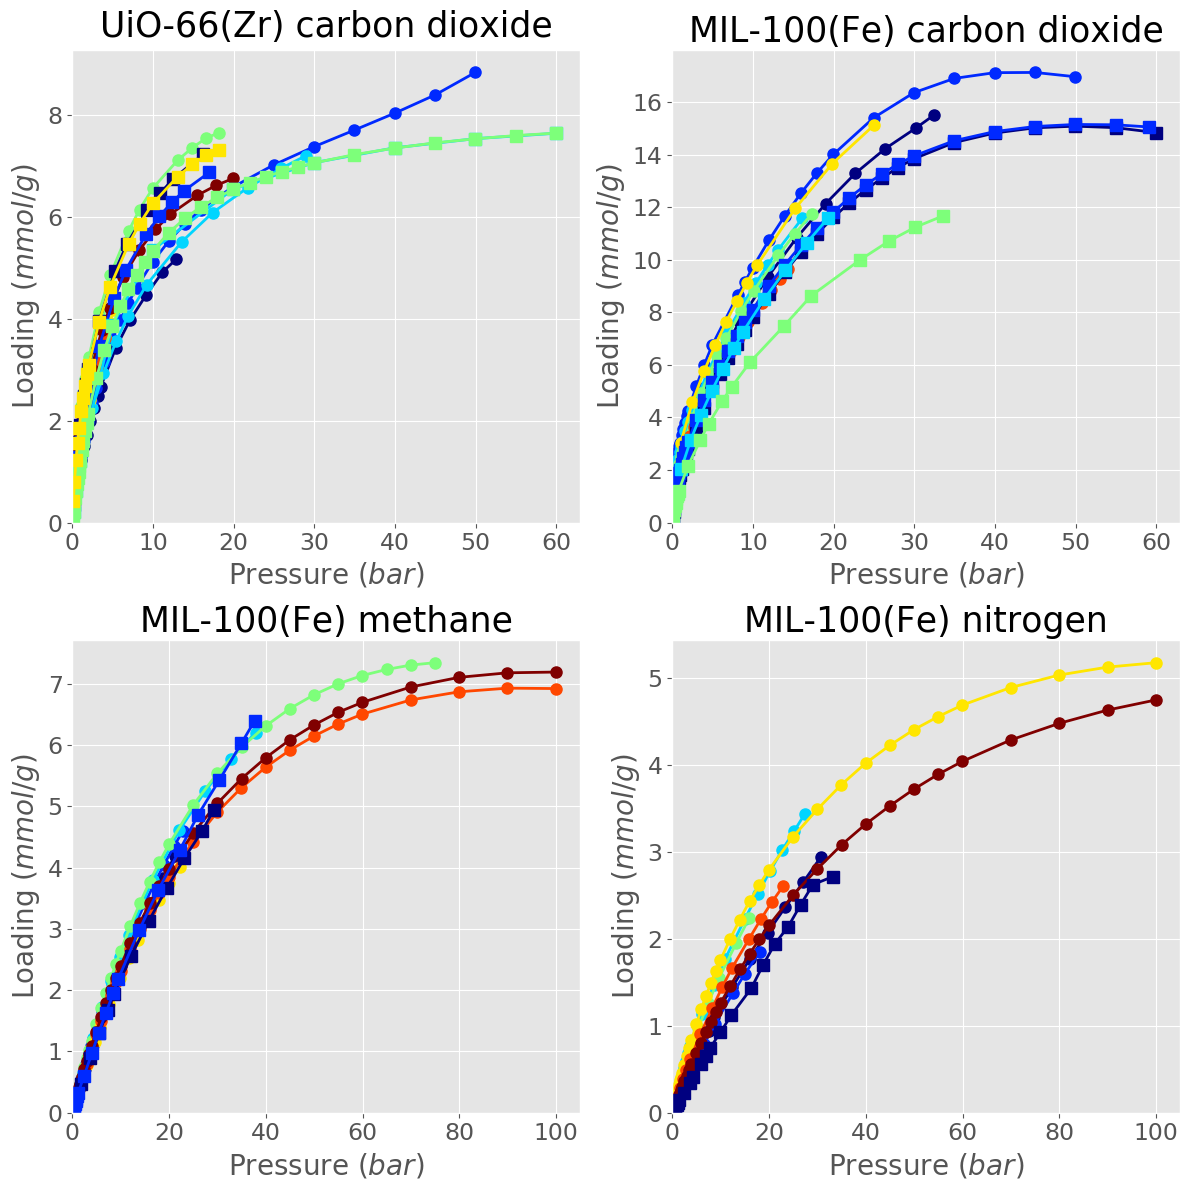

In [140]:
fig, axs = plt.subplots(2,2, figsize=(12, 12))
axs = axs.reshape(-1)

for index, (tpl, _) in enumerate(top):
    pygaps.plot_iso(
        [iso for iso in iso_madirel if iso.material == tpl[0] and iso.adsorbate == tpl[1] and iso.temperature == tpl[2]], 
        ax=axs[index], lgd_pos=None, branch='ads', fig_title=(tpl[0] + ' ' + tpl[1]))
        
plt.savefig("./madirel-example-isotherms.png", dpi=300,
            bbox_inches='tight', bbox_extra_artists=[legend1, legend2])
plt.show()